# COVID Disinformation on Social Media
## Matthew Fikes
## DSC 680 Project 3

In [72]:
import praw
import os
from dotenv import load_dotenv
import urllib.request, json
import pandas as pd
import ast
import matplotlib.pyplot as plt
import time
import numpy as np

### Set up connection to Reddit via PRAW

In [73]:
load_dotenv()
reddit = praw.Reddit(
    client_id=os.getenv('client_id'),
    client_secret=os.getenv('client_secret'),
    password=os.getenv('password'),
    user_agent=os.getenv('user_agent'),
    username='mattreyu',
)

In [74]:
# Check to make sure API is logged in as user with write privileges
reddit.read_only

False

### Select Subreddits to Explore Moderator Activity

In [75]:
disinfo_subs = ['LockdownSkepticism','TakeTheJab','DebateVaccines','conspiracy']


In [145]:
# get counts of top posts for the day
for i in disinfo_subs:
    
    count = 0
    for j in reddit.subreddit(i).top("day"):
        count += 1
    print(i,count)

LockdownSkepticism 43
TakeTheJab 13
DebateVaccines 31
conspiracy 100


In [ ]:
# moderator list for banned NoNewNormal subreddit for later research
# nnn_mods = ['SpiderImAlright','evergreen193','coolchewlew','hab-bib','QueenRowana','freshhy88','MrsClawbster','Harryisamazing','CrimsonSun99']

### Define functions to get user and community data

In [76]:
# get creation date of user account in years
def account_age(user):
    user = reddit.redditor(str(user))
    curr_time = time.time()    
    try:
        cakeday = user.created_utc
    except:
        print("Unable to obtain cakeday for ", user)
        return
    acct_age = round((curr_time-user.created_utc)/31557600,2)
    return(acct_age)

In [77]:
# return count of posts in each subreddit as allowed by API
def post_subs(user):
    subreddits = dict()
    try:
        for record in user.submissions.new(limit=None):       
            if record.subreddit.display_name in subreddits:
                subreddits[record.subreddit.display_name] += record.score        
            else: 
                subreddits[record.subreddit.display_name] = record.score  
        data = {k: v for k, v in sorted(subreddits.items(), key=lambda item: item[1],reverse=True)[:10]}             
    except:
        return(subreddits)
        
            
    return(data)    

In [78]:
def comment_subs(user):
    subreddits = dict()
    try:
        for record in user.comments.new(limit=None):
        
            if record.subreddit.display_name in subreddits:
                subreddits[record.subreddit.display_name] += record.score
        
            else: 
                subreddits[record.subreddit.display_name] = record.score
        
        data = {k: v for k, v in sorted(subreddits.items(), key=lambda item: item[1],reverse=True)[:10]}        
    except:
        return(subreddits)
    return(data)
    

In [79]:
# get list of moderators for a subreddit as a dataframe
def ReturnMods(sub):
    
    users = []
    post_karma = []
    comment_karma = []
    
    try:
        moderator_list = reddit.subreddit(sub).moderator()
    except:
        print("Unable to get mods for ",sub)
        return
    
    for redditor in moderator_list:
        user = redditor.name
        
        if user=='AutoModerator': # filter out AutoModerator data 
            continue
        else:
            try:
                post_karma.append(post_subs(reddit.redditor(user)).get(sub))
            except:
                print("Could not get post karma for user:",user)
                post_karma.append(None)                    
                
            try:    
                comment_karma.append(comment_subs(reddit.redditor(user)).get(sub))
            except:
                print("Could not get comment karma for user:",user)
                comment_karma.append(None)
                
            users.append(user)
    df = pd.DataFrame({'subreddit': sub, 'user':users,'post karma':post_karma,'comment karma':comment_karma})
    return(df)
        

In [82]:
# get list of subreddit post authors, sorted by post count
def subreddit_posters(sub):
    submitter = dict()
    for submission in reddit.subreddit(sub).hot(limit=None):
        try:
            if submission.author.name in submitter:
                
                submitter[submission.author.name] += 1
            else:
                submitter[submission.author.name] = 1
        except:
            continue
    data = {k: v for k, v in sorted(submitter.items(), key=lambda item: item[1],reverse=True)}        
    df = pd.DataFrame.from_dict(data,orient='index',columns=['posts'])
    df['sub'] = sub
    return(df)

In [83]:
#function to get unique list of subreddits that are interacted with by a list of users
def post_comment_subs(df):
    post_subreddits = []
    comment_subreddits = []
    for row,value in df.iterrows():
        
        #posts = dict(value.posts)
        posts = ast.literal_eval(value.posts)
        #comments = dict(value.comments)
        comments = ast.literal_eval(value.comments)
        post_subs = posts.keys()
        com_subs = comments.keys()
        for psub in post_subs:
            post_subreddits.append(psub)
        for csub in com_subs:
            comment_subreddits.append(csub)
    
    sublist = list(set(post_subreddits+comment_subreddits))
    
    
    return(sublist)

In [84]:
#function to get unique list of subreddits that are interacted with by a list of users
def fill_sub_cols(df):

    for row,value in df.iterrows():
        
        posts = ast.literal_eval(value.posts)
        #posts = dict(value.posts)
        
        comments = ast.literal_eval(value.comments)
        #comments = dict(value.comments)
        
        
        for k,v in posts.items():
            
            p_index = df.columns.get_loc(k)
            curr_val = df.iloc[row][p_index]
            df.at[row,k] = v
                        
        for k,v in comments.items():
            c_index = df.columns.get_loc(k)
            curr_val = df.iloc[row][c_index]
            if curr_val > 0:
                
                df.at[row,k] += v
                
            else:
                
                df.at[row,k] = v 
 
    return(df)

In [85]:
# gets number of subscribers for a subreddit
def subscriber_count(sub):
    sub_count = reddit.subreddit(sub).subscribers
    return(sub_count)

### Retrieve Moderator Information

In [304]:
disinfo_mods = pd.concat([ReturnMods(x) for x in disinfo_subs])
disinfo_mods['posts'] = [post_subs(reddit.redditor(x)) for x in disinfo_mods['user']]
disinfo_mods['comments'] = [comment_subs(reddit.redditor(x)) for x in disinfo_mods['user']]

In [86]:
# uncomment to save to excel or load processed data in
#disinfo_mods.to_excel('mod_list.xls')
#disinfo_mods = pd.read_excel('mod_list.xls',usecols="B:H")

In [87]:
subs = post_comment_subs(disinfo_mods) # get communities moderators interact with (top 10)
sub_df = pd.DataFrame(columns=subs) # create df of columns
disinfo_data = pd.concat([disinfo_mods,sub_df]) # join with moderator data

In [88]:
# print unique posters
len(disinfo_data['user'].unique())

55

In [90]:
data = fill_sub_cols(disinfo_data)

## List top communities that disinformation moderators interact with

In [91]:
sum_data= data.drop(columns=['user','post karma','comment karma','posts','comments']) # get rid of text fields

In [92]:
# format user data for network graph
totals = sum_data.groupby('subreddit').sum().reset_index()
total_df = totals.melt(id_vars='subreddit',var_name='target',value_name='weight')

In [95]:
# get unique subreddits
unique_subs = list(total_df['target'].unique())
sub_count = [subscriber_count(x) for x in unique_subs]
uniques = pd.DataFrame(list(zip(unique_subs,sub_count)),columns=['target','sub_count'])
unique_count = uniques.set_index('target').to_dict()['sub_count']

In [96]:
# merge counts for each unique subreddit
total_data = pd.merge(total_df,uniques,on='target',how='inner')
test_df = total_data.sort_values(by='weight',ascending=False)[0:100]
test_df.rename(columns={'sub_count':'value'},inplace=True)

### Moderator Network Graphs

In [119]:
# make network plot for moderators
import networkx as nx

G = nx.from_pandas_edgelist(test_df,
                           source='subreddit',
                           target='target',
                           edge_attr='weight')
nx.set_node_attributes(G, unique_count, "subscribers")
node_size = [2*np.sqrt(nx.get_node_attributes(G,'subscribers')[v]) for v in G]


In [120]:
# make interactive plot for moderators
from pyvis.network import Network
net = Network(notebook=True,height='1000px', width='100%', bgcolor='#fffff', font_color='black')
sources = test_df['subreddit']
targets = test_df['target']
weights = np.sqrt(test_df['weight'])
values = test_df['value']
edge_data = zip(sources,targets,weights,values)

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]
    v = e[3]
    
    net.add_node(src,src,title=src)
    net.add_node(dst,dst,title=dst,size=v)
    net.add_edge(src,dst,value=w)
    
neighbor_map = net.get_adj_list()

for node in net.nodes:
    node['title'] += ' Neighbors:<br>' + '<br>'.join(neighbor_map[node['id']])
    node['value'] = len(neighbor_map[node['id']])

net.show('example1.html')

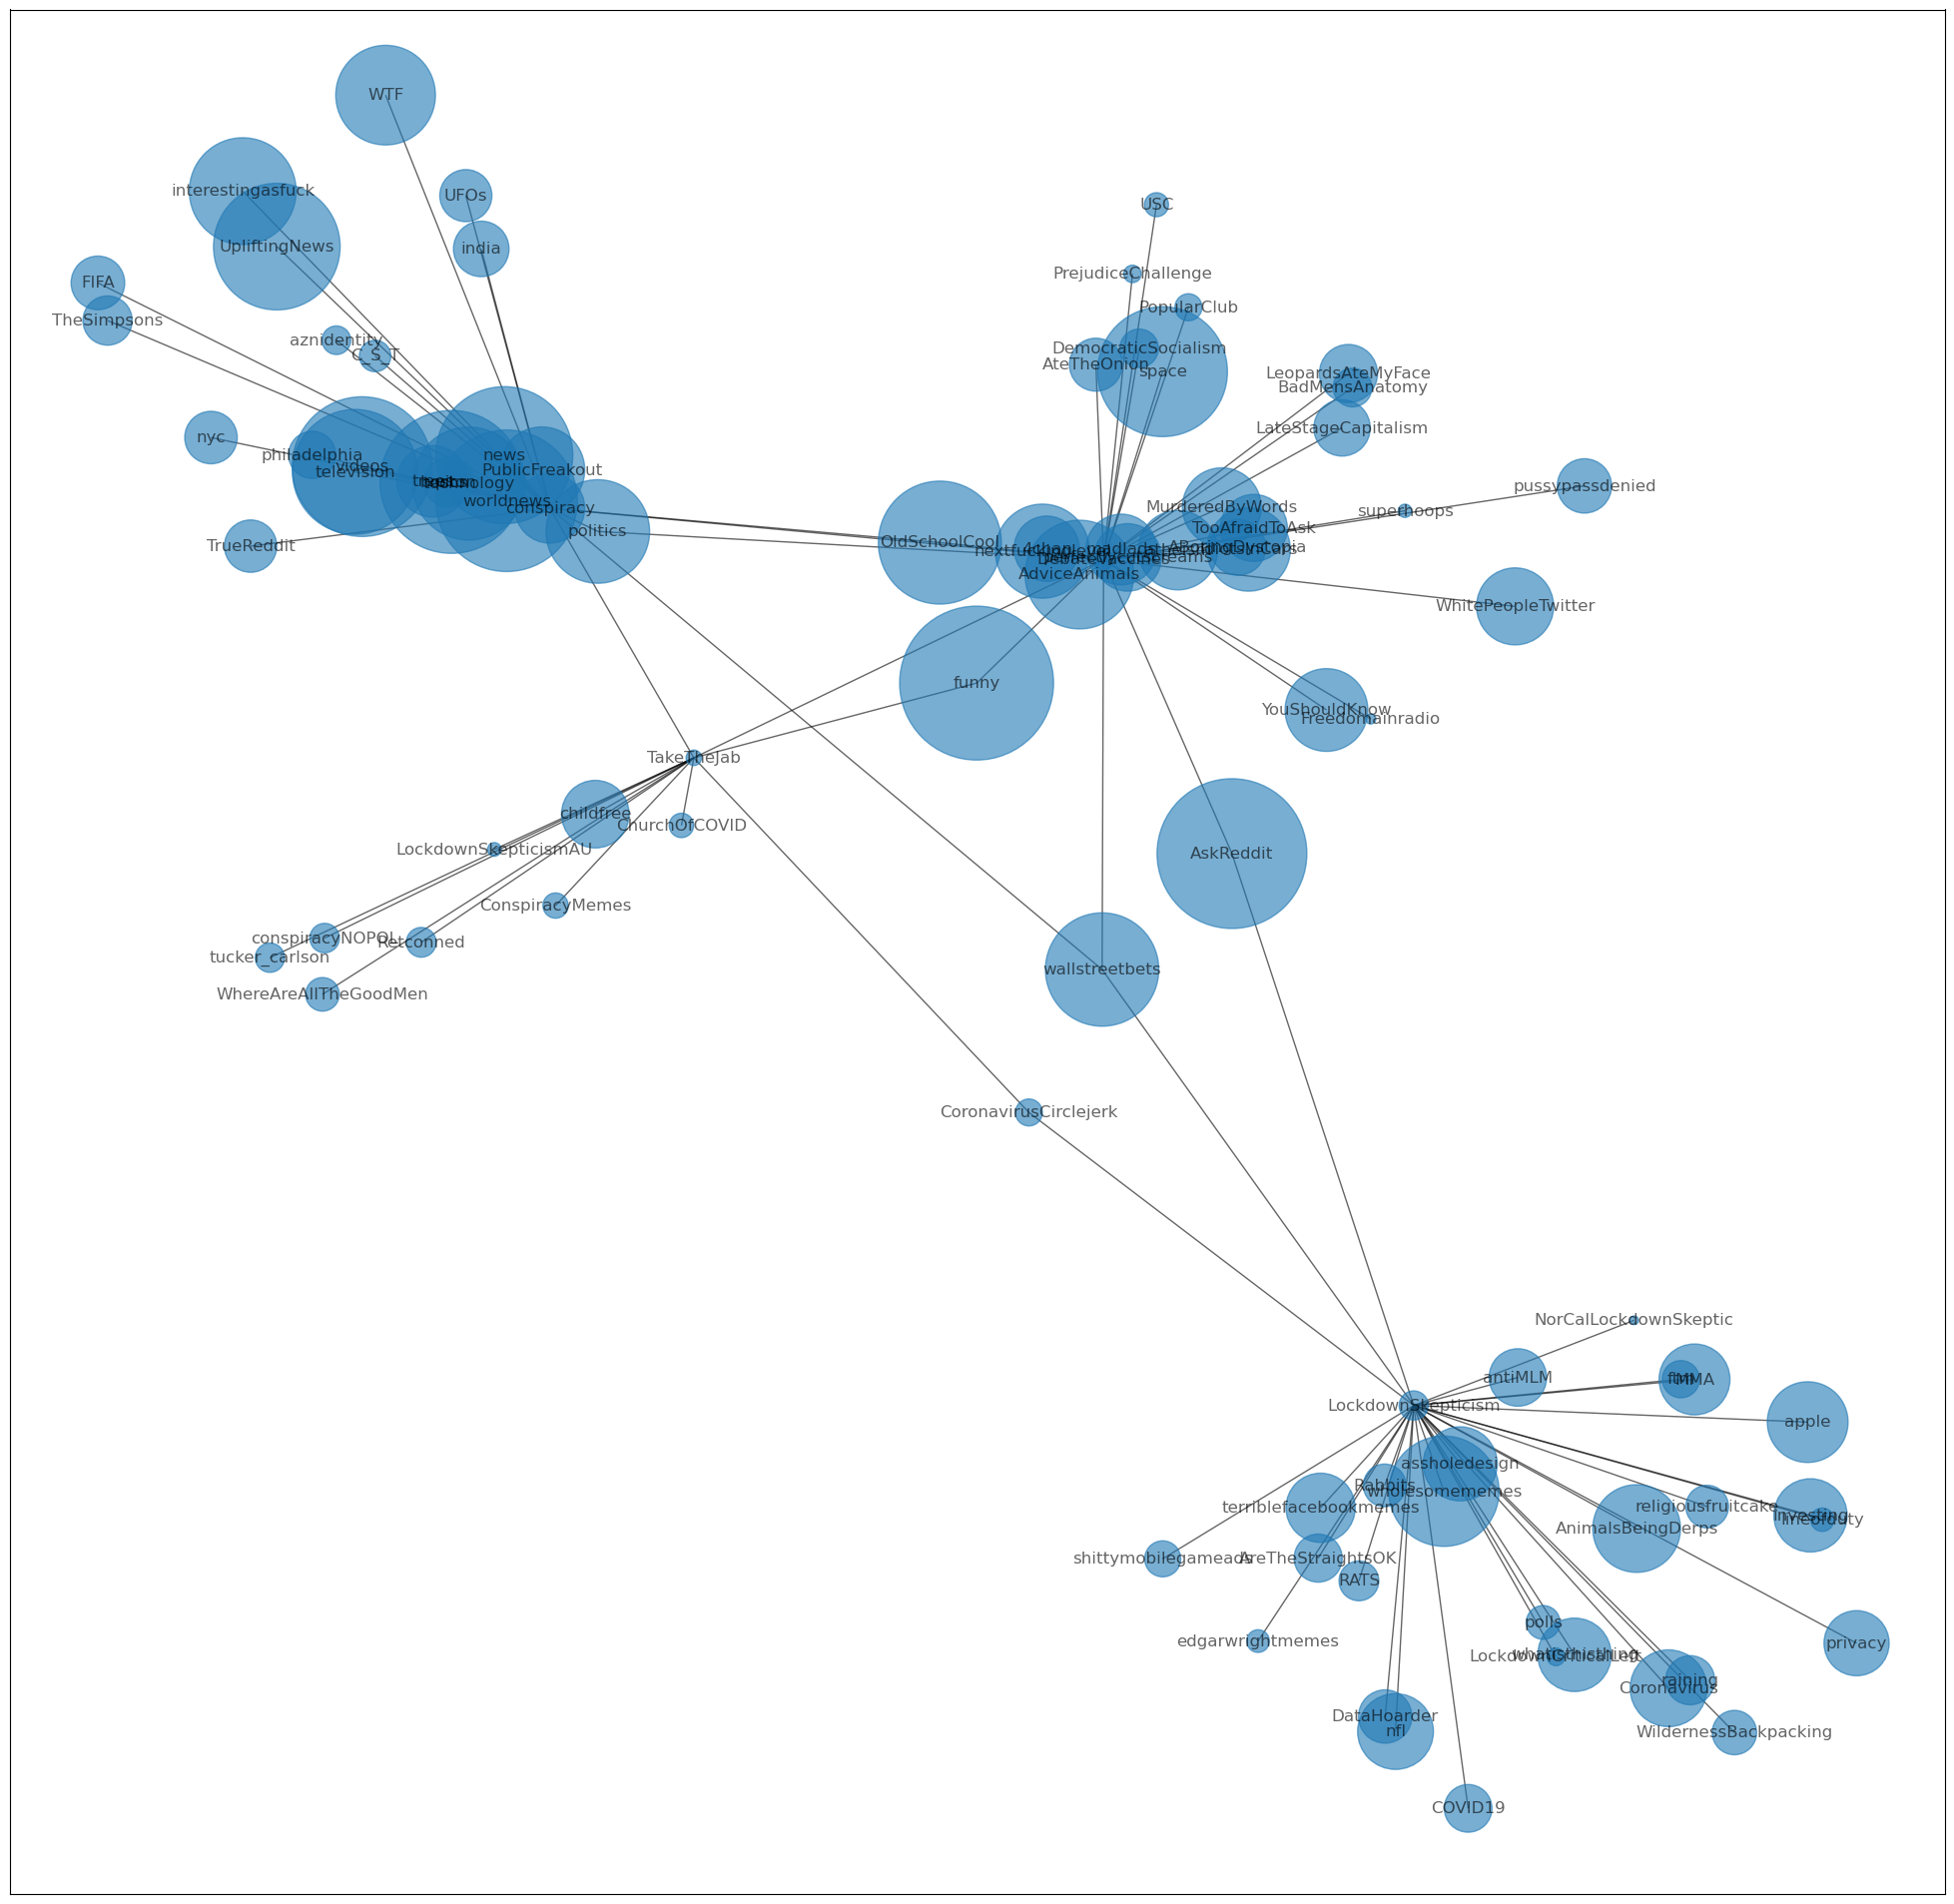

In [121]:
# make network graph for moderators
fig = plt.figure(1, figsize=(25, 25), dpi=100)

node_size = [2*np.sqrt(nx.get_node_attributes(G,'subscribers')[v]) for v in G]
nx.set_node_attributes(G, unique_count, "subscribers")
nx.draw_networkx(G,node_size=node_size,alpha=0.6)


### Barplots for Moderator Post Activity

In [107]:
# make cross index
total_idx = totals.set_index('subreddit')
cross_sub_activity = (total_idx >0).sum().sort_values(ascending=False)[0:50]

Text(0.5, 0, '# of target subs with moderators posting')

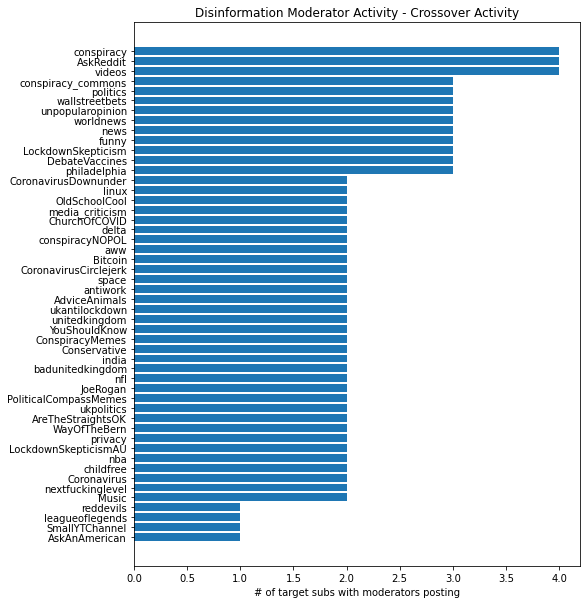

In [114]:
# plot crossover activity for moderators
plt.figure(figsize=(8,10))
plt.barh(width=cross_sub_activity.values,y=cross_sub_activity.index)
plt.gca().invert_yaxis()
plt.title('Disinformation Moderator Activity - Crossover Activity')
plt.xlabel('# of target subs with moderators posting')


Text(0.5, 0, 'Combined karma earned from posts/comments')

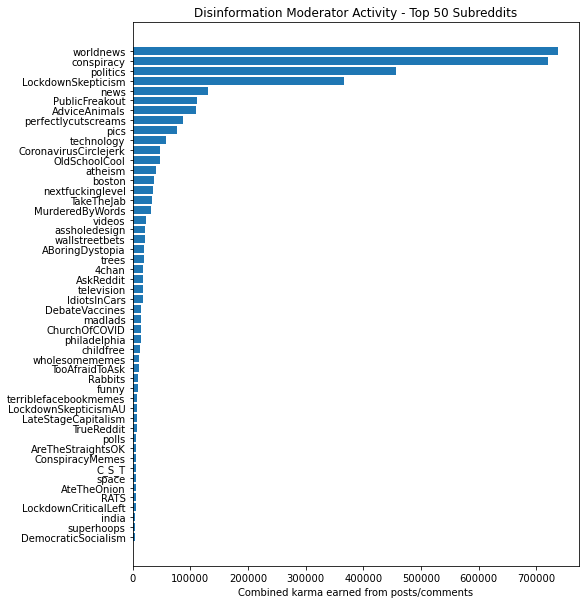

In [111]:
# get top 50 subs for activity
top_50_mod_subs = total_idx.sum().sort_values(ascending=False)[0:50]
plt.figure(figsize=(8,10))
plt.barh(width=top_50_mod_subs.values,y=top_50_mod_subs.index)
plt.gca().invert_yaxis()
plt.title('Disinformation Moderator Activity - Top 50 Subreddits')
plt.xlabel('Combined karma earned from posts/comments')

### Check people who post in disinformation communities

In [137]:
poster_data = [subreddit_posters(x) for x in disinfo_subs]
submitters = pd.concat(poster_data).reset_index()

In [139]:
# find users who post to more than one target sub
submitters['index'].value_counts(ascending=False)[0:50]

lh7884                  3
BBJackie                3
tortugavelozzzz         3
goodenoug4now           3
peetss                  3
Settlemente             2
1bir                    2
lucycohen               2
_GERIATRIC_GEEZER_GG    2
Available_Chonkus       2
ThisAd7328              2
museumsplendor          2
N4T11                   2
Heel74                  2
stuuked                 2
edshire                 2
earthcomedy             2
LumpyGravy21            2
CuriesGhost             2
Gregmiller20201         2
Mighty_L_LORT           2
CapableSprinkles2742    2
syndicatedmaps          2
35quai                  2
HulkTogan               2
Li529iL                 2
TyquanWorldMessi        2
thelibertarianideal     2
sol_sleepy              2
geneticshill            2
Skirkyn                 2
brand2030               2
KooKooforCovidPuffs     2
OrwellWasRight69        2
Apprehensive_Cod5424    2
dixie8123               1
JannTosh12              1
orangearbuds            1
PabloGaruda8

In [140]:
submitter_df = submitters.sort_values(by='posts',ascending=False).head(50)
submitter_nodup = submitters.drop_duplicates('index').sort_values(by='posts',ascending=False).head(50)
submitter_nodup['posts'] = [post_subs(reddit.redditor(x)) for x in submitter_nodup['index']]
submitter_nodup['comments'] = [comment_subs(reddit.redditor(x)) for x in submitter_nodup['index']]

In [45]:
# uncomment to save or load
#submitter_nodup.to_excel('user_data.xls')
#submitter_nodup = pd.read_excel('user_data.xls',usecols="B:E")

In [46]:
poster_subs = post_comment_subs(submitter_nodup) # get communities moderators interact with (top 10)
poster_sub_df = pd.DataFrame(columns=poster_subs) # create df of columns
disinfo_user_data = pd.concat([submitter_nodup,poster_sub_df])

In [47]:
# format user data for network graph
user_data = fill_sub_cols(disinfo_user_data)
user_sum= user_data.drop(columns=['index','posts','comments'])
user_totals = user_sum.groupby('sub').sum().reset_index()
user_total_df = user_totals.melt(id_vars='sub',var_name='target',value_name='weight')

In [52]:
unique_user_subs = list(user_total_df['target'].unique())
user_sub_count = [subscriber_count(x) for x in unique_user_subs]
user_uniques = pd.DataFrame(list(zip(unique_user_subs,user_sub_count)),columns=['target','sub_count'])
user_unique_count = user_uniques.set_index('target').to_dict()['sub_count']

In [53]:
user_total_data = pd.merge(user_total_df,user_uniques,on='target',how='inner')
user_df = user_total_data.sort_values(by='weight',ascending=False)[0:100]

### User Network Graphs

In [149]:
from pyvis.network import Network
net = Network(notebook=True,height='1000px', width='100%', bgcolor='#fffff', font_color='black')
#net.barnes_hut()
#net.from_nx(G)
sources = user_df['sub']
targets = user_df['target']
weights = np.sqrt(user_df['weight'])
values = np.sqrt(user_df['sub_count'])
edge_data = zip(sources,targets,weights,values)

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]
    v = e[3]
    
    net.add_node(src,src,title=src,value=v)
    net.add_node(dst,dst,title=dst,size=v)
    net.add_edge(src,dst,value=w)
    
neighbor_map = net.get_adj_list()

for node in net.nodes:
    node['title'] += ' Neighbors:<br>' + '<br>'.join(neighbor_map[node['id']])
    node['value'] = len(neighbor_map[node['id']])

net.show_buttons()

net.show('example.html')


In [55]:
import networkx as nx

G2 = nx.from_pandas_edgelist(user_df,
                           source='sub',
                           target='target',
                           edge_attr='weight',
                           )


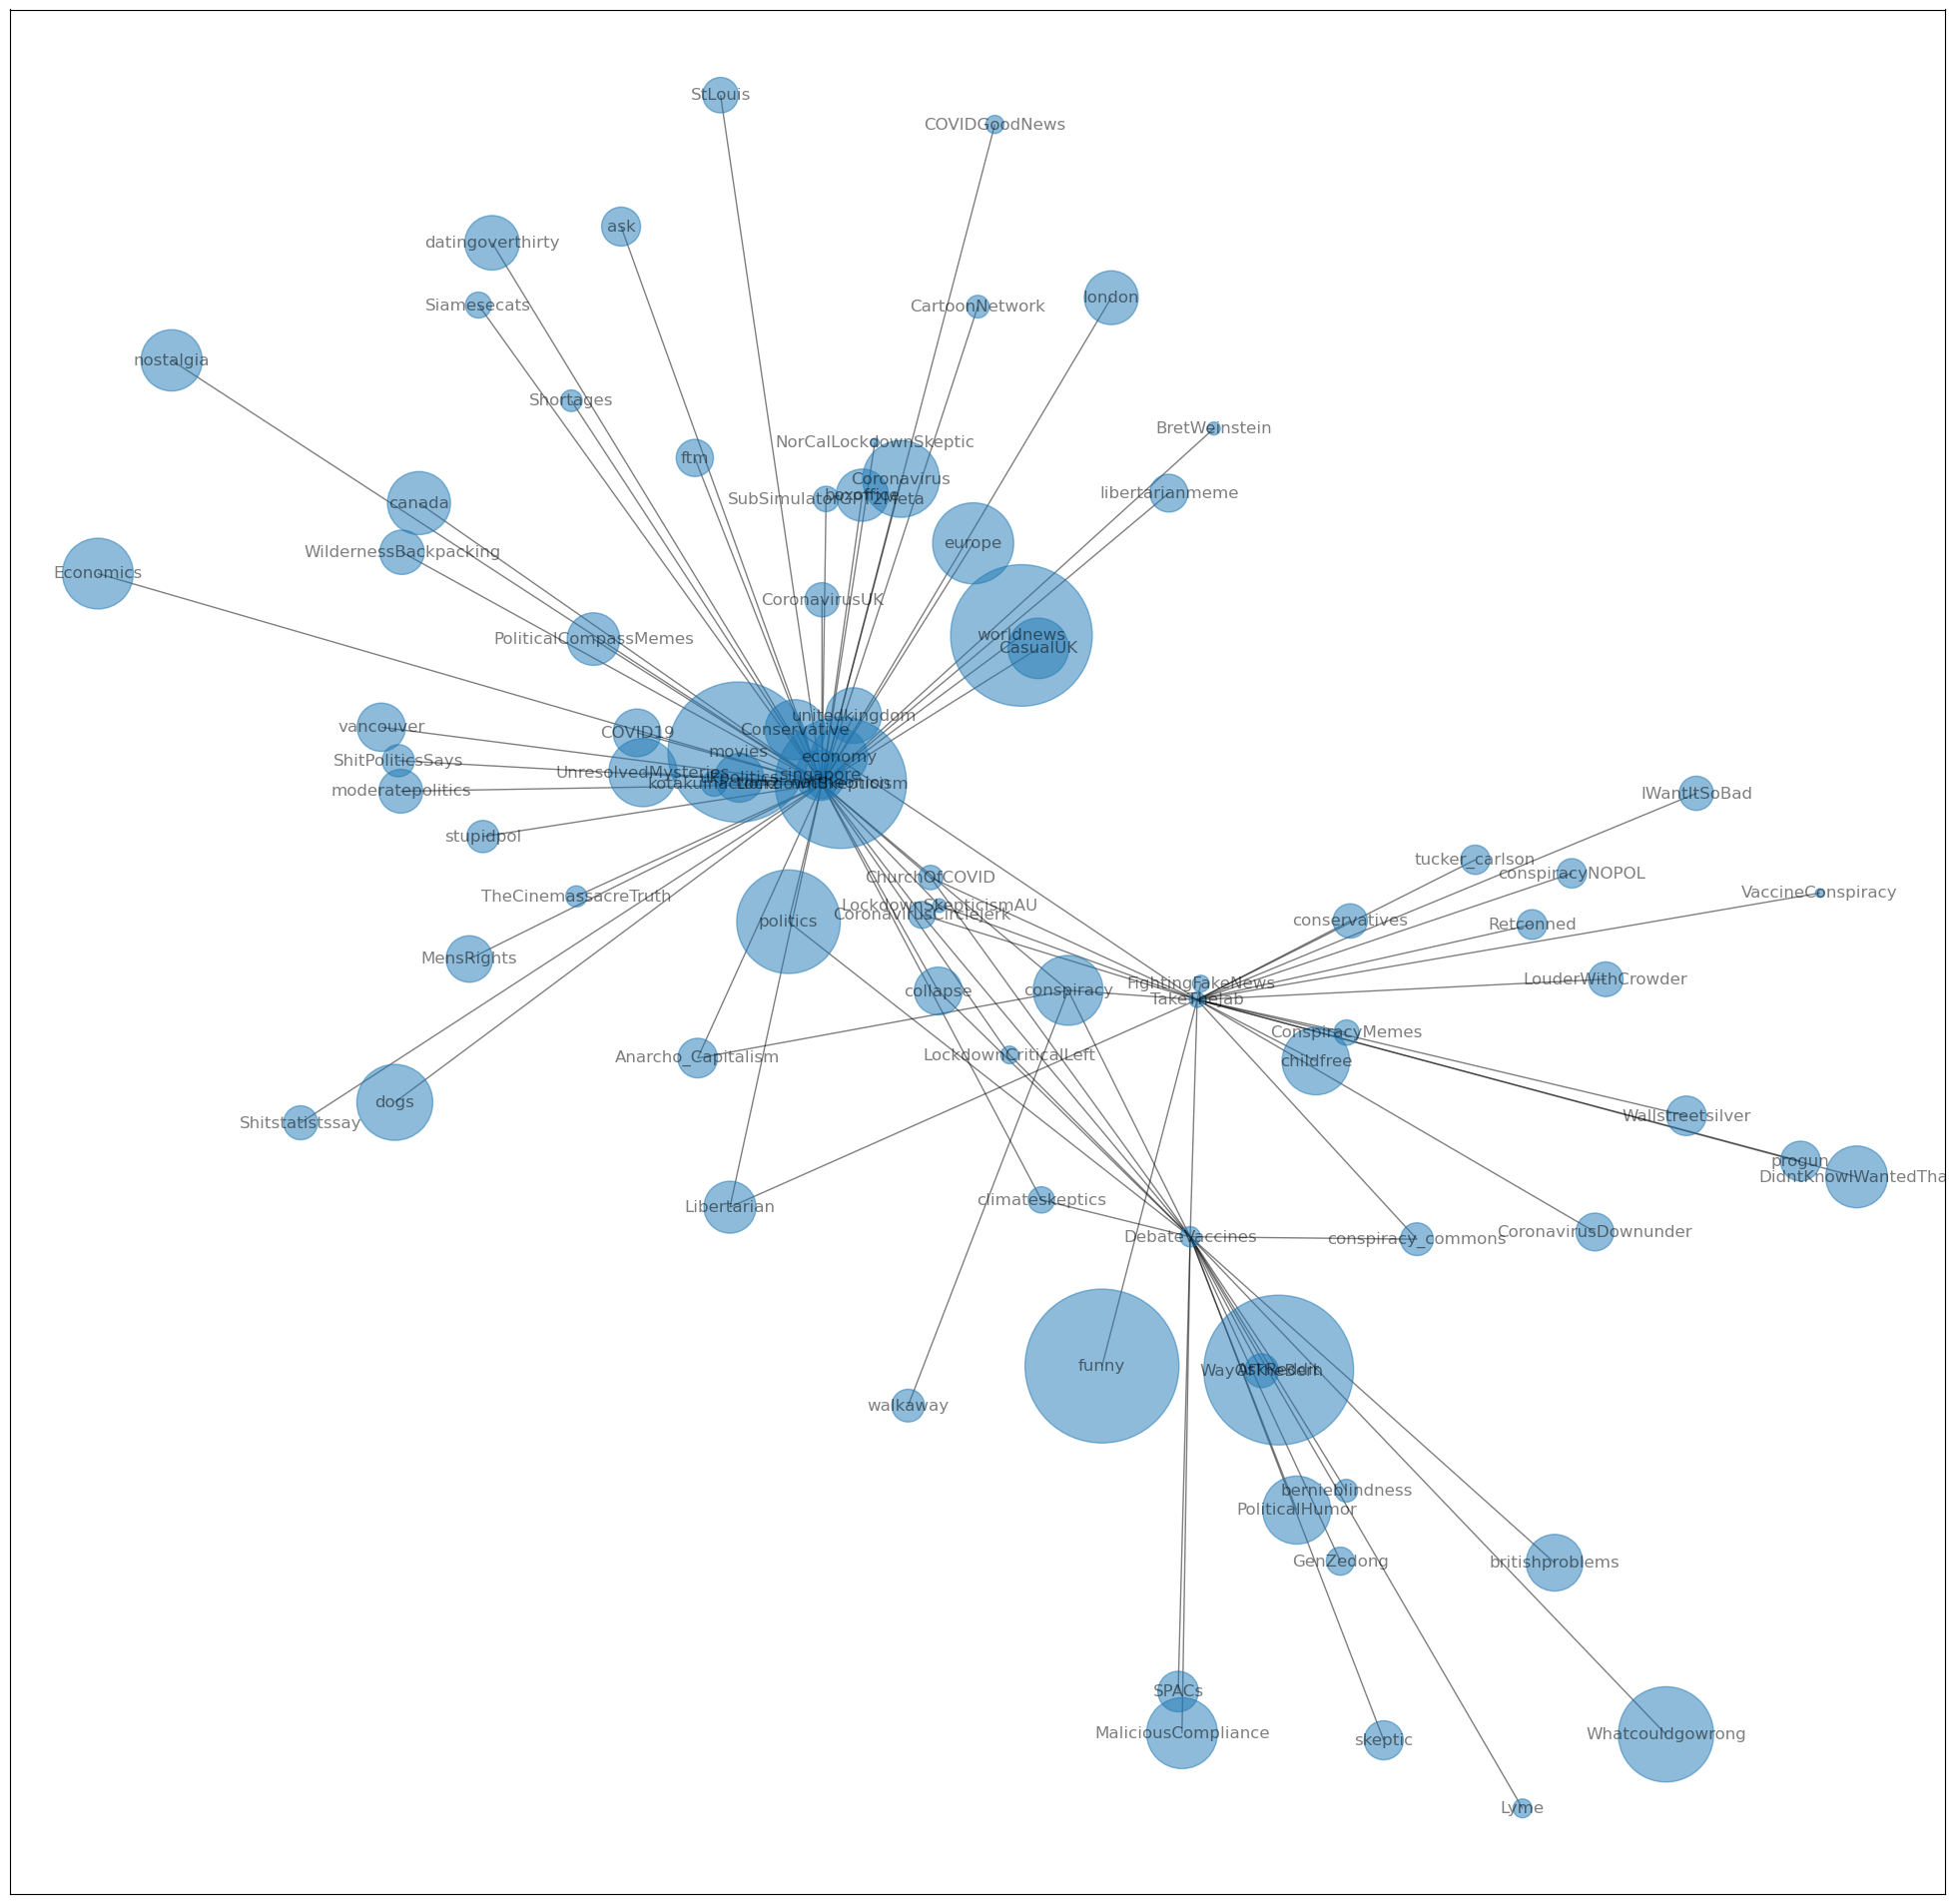

In [122]:
fig = plt.figure(1, figsize=(25, 25), dpi=100)
nx.set_node_attributes(G2, user_unique_count, "subscribers")
node_size = [2*np.sqrt(nx.get_node_attributes(G2,'subscribers')[v]) for v in G2]

nx.draw_networkx(G2,node_size=node_size,alpha=0.5)

### Barplots for User Post Activity

In [99]:
u_total_idx = user_totals.set_index('sub')

In [100]:
u_cross_sub_activity = (u_total_idx >0).sum().sort_values(ascending=False)[0:50]

Text(0.5, 0, '# of target subs with moderators posting')

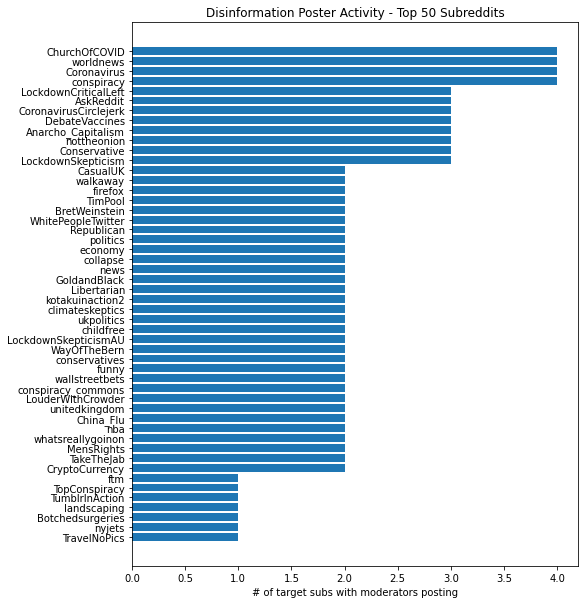

In [113]:
plt.figure(figsize=(8,10))
plt.barh(width=u_cross_sub_activity.values,y=u_cross_sub_activity.index)
plt.gca().invert_yaxis()
plt.title('Disinformation Poster Activity - Top 50 Subreddits')
plt.xlabel('# of target subs with moderators posting')

In [103]:
top_50_user_subs = u_total_idx.sum().sort_values(ascending=False)[0:50]

Text(0.5, 0, 'Combined karma earned from posts/comments')

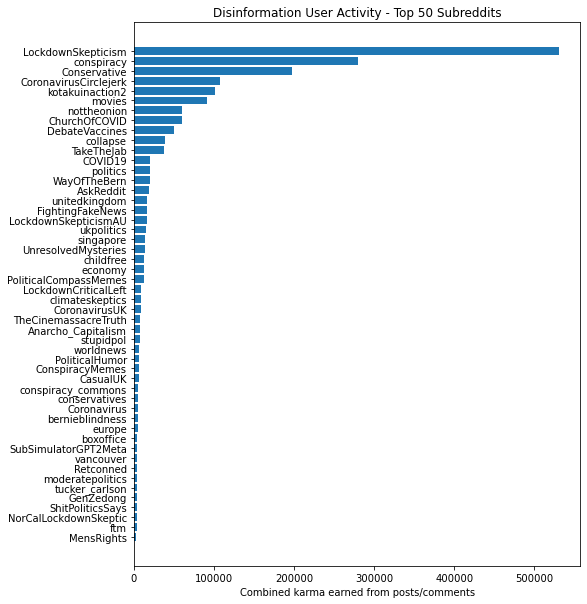

In [112]:
plt.figure(figsize=(8,10))
plt.barh(width=top_50_user_subs.values,y=top_50_user_subs.index)
plt.gca().invert_yaxis()
plt.title('Disinformation User Activity - Top 50 Subreddits')
plt.xlabel('Combined karma earned from posts/comments')